In [ ]:
#classifying students in a university on the country they are from

In [25]:
#Install the required libraries
!pip install torch_geometric
!pip install optuna

In [26]:
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [28]:
# Load the dataset
dataset = KarateClub()
data = dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [29]:
print(dataset.num_features)

34


In [30]:
import pandas as pd

# Convert node features, edge indices, and labels to pandas DataFrames
node_features_df = pd.DataFrame(data.x.numpy(), columns=[f'feature_{i}' for i in range(data.x.shape[1])]).set_index(pd.Index(range(data.x.size(0)), name='node'))

edge_index_df = pd.DataFrame(data.edge_index.numpy().T, columns=['source', 'target'])

labels_df = pd.DataFrame({'label': data.y.numpy()}, index=pd.Index(range(data.y.size(0)), name='node'))

print(len(edge_index_df))


156


In [32]:
#features values shows which node is connected to another node.
#like A connected to B will be (0,1)
print(node_features_df)


      feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
node                                                                     
0           1.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        1.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        1.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        1.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        1.0        0.0   
5           0.0        0.0        0.0        0.0        0.0        1.0   
6           0.0        0.0        0.0        0.0        0.0        0.0   
7           0.0        0.0        0.0        0.0        0.0        0.0   
8           0.0        0.0        0.0        0.0        0.0        0.0   
9           0.0        0.0        0.0        0.0        0.0        0.0   
10          0.0        0.0        0.0        0.0        0.0        0.0   
11          0.0        0.0        0.0 

In [33]:
num_nodes = data.num_nodes
print(f"Number of nodes: {num_nodes}")
# Print the number of edges
num_edges = data.edge_index.shape[1]
print(f"Number of edges: {num_edges}")

Number of nodes: 34
Number of edges: 156


In [34]:
# This shows which nodes 0 is connected to which are 0 to 1, 0 to 2, 0 to 3, 0 to 4, 0 to 5
print(f"\nEdge indices (shape: {edge_index_df.shape}):")
print(edge_index_df.head())


Edge indices (shape: (156, 2)):
   source  target
0       0       1
1       0       2
2       0       3
3       0       4
4       0       5


In [37]:
# this is for classification like 0 to 1 is label 1, 1 to 3 is label 1
#4 to 0 is label 3. This is for classsifcation purpose
print(f"\nLabels (shape: {labels_df.shape}):")
print(labels_df.head())


Labels (shape: (34, 1)):
      label
node       
0         1
1         1
2         1
3         1
4         3


In [40]:
# Gives nodes to each countries
num_countries = 5

np.random.seed(2)
countries = torch.tensor(np.random.choice(num_countries, data.num_nodes))

data.y = countries
print(data.y)

tensor([0, 0, 3, 2, 3, 0, 2, 1, 3, 2, 4, 4, 4, 3, 4, 2, 3, 3, 2, 1, 2, 4, 3, 0,
        4, 3, 1, 2, 0, 4, 4, 2, 4, 2])


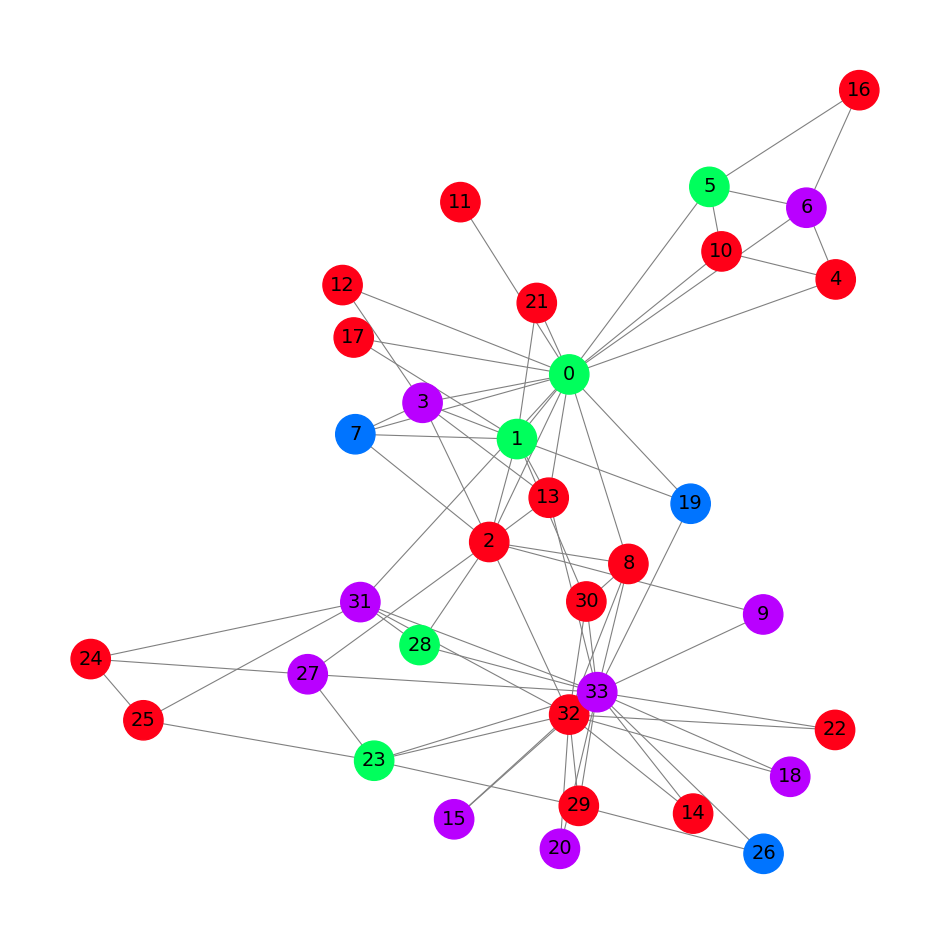

In [43]:
# This graph shows how they are connected based on countries
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

In [55]:
# Define the model
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 5)
        self.out = Linear(5, num_countries)
    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

model = GCN()
print(model)


GCN(
  (gcn): GCNConv(34, 5)
  (out): Linear(in_features=5, out_features=5, bias=True)
)


In [56]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)


In [57]:
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(200):
    optimizer.zero_grad()
    h, z = model(data.x, data.edge_index)
    loss = criterion(z, data.y)
    acc = accuracy(z.argmax(dim=1), data.y)
    loss.backward()
    optimizer.step()
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')


Epoch   0 | Loss: 1.68 | Acc: 17.65%
Epoch  10 | Loss: 1.42 | Acc: 44.12%
Epoch  20 | Loss: 1.21 | Acc: 52.94%
Epoch  30 | Loss: 0.95 | Acc: 67.65%
Epoch  40 | Loss: 0.69 | Acc: 82.35%
Epoch  50 | Loss: 0.48 | Acc: 97.06%
Epoch  60 | Loss: 0.31 | Acc: 100.00%
Epoch  70 | Loss: 0.18 | Acc: 100.00%
Epoch  80 | Loss: 0.11 | Acc: 100.00%
Epoch  90 | Loss: 0.07 | Acc: 100.00%
Epoch 100 | Loss: 0.05 | Acc: 100.00%
Epoch 110 | Loss: 0.04 | Acc: 100.00%
Epoch 120 | Loss: 0.03 | Acc: 100.00%
Epoch 130 | Loss: 0.02 | Acc: 100.00%
Epoch 140 | Loss: 0.02 | Acc: 100.00%
Epoch 150 | Loss: 0.02 | Acc: 100.00%
Epoch 160 | Loss: 0.01 | Acc: 100.00%
Epoch 170 | Loss: 0.01 | Acc: 100.00%
Epoch 180 | Loss: 0.01 | Acc: 100.00%
Epoch 190 | Loss: 0.01 | Acc: 100.00%


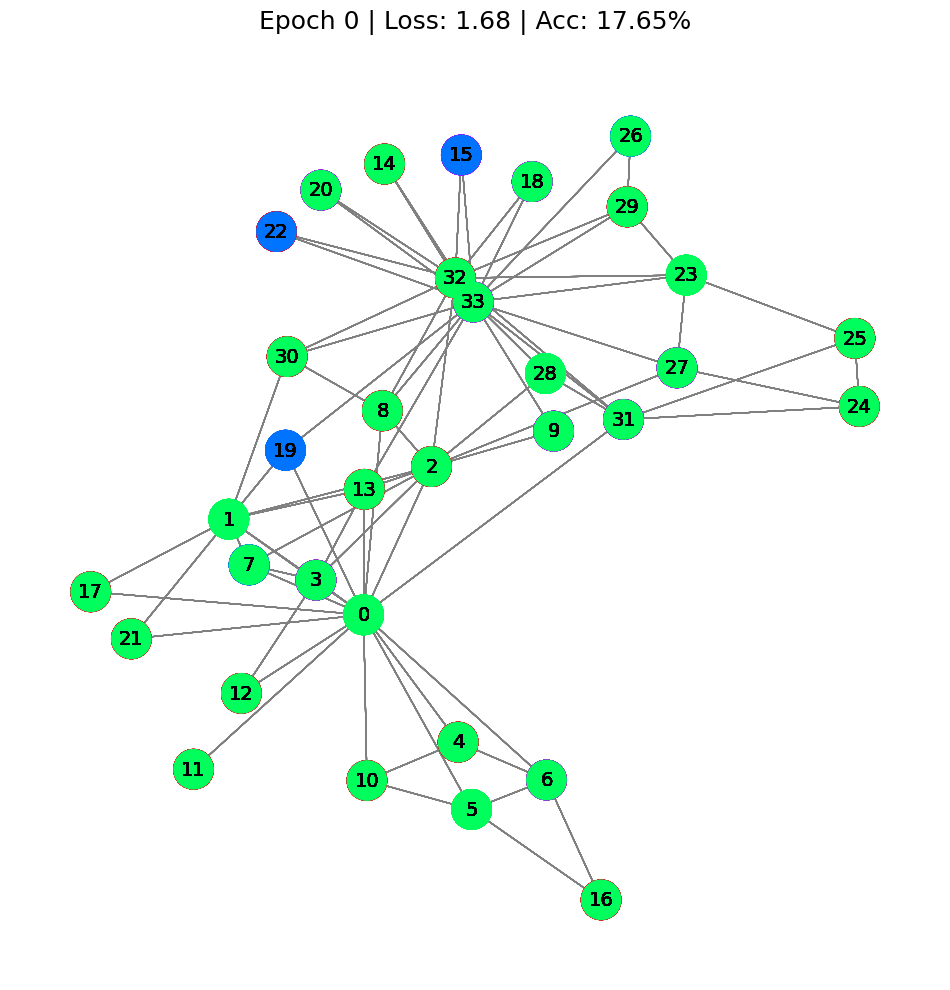

In [58]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=11),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i].numpy(),
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i].item():.2f} | Acc: {accuracies[i].item()*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)